In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
op_1 = pd.read_csv('../data/raw/opel_corsa_01.csv', sep=';', decimal=',')
op_2 = pd.read_csv('../data/raw/opel_corsa_02.csv', sep=';', decimal=',')
peug_1 = pd.read_csv('../data/raw/peugeot_207_01.csv', sep=';', decimal=',')
peug_2 = pd.read_csv('../data/raw/peugeot_207_02.csv', sep=';', decimal=',')

All datasets have the same number of columns

In [3]:
print('Opel Corsa 1: Rows: {}, Columns: {}'.format(op_1.shape[0], op_1.shape[1]))
print('Opel Corsa 2: Rows: {}, Columns: {}'.format(op_2.shape[0], op_2.shape[1]))
print('Peugeot 207 1: Rows: {}, Columns: {}'.format(peug_1.shape[0], peug_1.shape[1]))
print('Peugeot 207 2: Rows: {}, Columns: {}'.format(peug_2.shape[0], peug_2.shape[1]))

Opel Corsa 1: Rows: 7392, Columns: 17
Opel Corsa 2: Rows: 4328, Columns: 17
Peugeot 207 1: Rows: 8614, Columns: 17
Peugeot 207 2: Rows: 4623, Columns: 17


## Check all datasets have the same column headers

In [4]:
if set(op_1.columns) == set(op_2.columns) == set(peug_1.columns) == set(peug_2.columns):
    print('All datasets have the same column headers')

All datasets have the same column headers


## There shouldn't be any. But a quick sanity check to make sure there are no null values

Sneaky! There are still null values in the Peugeot datasets. These will be handled later.

In [61]:
op_1_missing = pd.DataFrame(op_1.isnull().sum()/op_1.shape[0]*100)
op_1_missing = op_1_missing[op_1_missing[0] > 0].reset_index()
op_1_missing.rename({'index': 'column_name', 0: 'missing_frequency'}, axis=1, inplace=True)

op_2_missing = pd.DataFrame(op_2.isnull().sum()/op_2.shape[0]*100)
op_2_missing = op_2_missing[op_2_missing[0] > 0].reset_index()
op_2_missing.rename({'index': 'column_name', 0: 'missing_frequency'}, axis=1, inplace=True)

peug_1_missing = pd.DataFrame(peug_1.isnull().sum()/peug_1.shape[0]*100)
peug_1_missing = peug_1_missing[peug_1_missing[0] > 0].reset_index()
peug_1_missing.rename({'index': 'column_name', 0: 'missing_frequency'}, axis=1, inplace=True)

peug_2_missing = pd.DataFrame(peug_2.isnull().sum()/peug_2.shape[0]*100)
peug_2_missing = peug_2_missing[peug_2_missing[0] > 0].reset_index()
peug_2_missing.rename({'index': 'column_name', 0: 'missing_frequency'}, axis=1, inplace=True)

In [62]:
op_1_missing

,column_name,missing_frequency
0,AltitudeVariation,0.730519
1,VehicleSpeedInstantaneous,0.094697
2,VehicleSpeedAverage,4.788961
3,VehicleSpeedVariance,4.788961
4,VehicleSpeedVariation,0.459957
5,FuelConsumptionAverage,1.312229


In [63]:
op_2_missing

,column_name,missing_frequency
0,AltitudeVariation,0.831793
1,VehicleSpeedInstantaneous,0.184843
2,VehicleSpeedAverage,5.452865
3,VehicleSpeedVariance,5.452865
4,VehicleSpeedVariation,0.878004
5,FuelConsumptionAverage,1.201479


In [64]:
peug_1_missing

,column_name,missing_frequency
0,AltitudeVariation,0.731368
1,VehicleSpeedInstantaneous,0.104481
2,VehicleSpeedAverage,4.817739
3,VehicleSpeedVariance,4.817739
4,VehicleSpeedVariation,0.905503
5,EngineLoad,0.058045
6,EngineCoolantTemperature,0.058045
7,ManifoldAbsolutePressure,0.058045
8,EngineRPM,0.058045
9,MassAirFlow,0.058045


In [65]:
peug_2_missing

,column_name,missing_frequency
0,AltitudeVariation,0.584036
1,VehicleSpeedInstantaneous,0.432620
2,VehicleSpeedAverage,3.828683
3,VehicleSpeedVariance,3.828683
4,VehicleSpeedVariation,0.821977
5,FuelConsumptionAverage,0.886870


## Dataset 1: Opel Corsa First Trip

### Correlation Heatmap

A couple of high correlations (```corr > 0.7```) emerge here:

```VehicleSpeedAverage``` and ```VehicleSpeedInstantaneous```

```VerticalAcceleration``` and ```LongitudinalAcceleration```

```VehicleSpeedInstantaneous``` and ```EngineRPM```

```VehicleSpeedInstantaneous``` and ```MassAirFlow```

Some mild correlations (```0.5 <= corr <= 0.7```):

```FuelConsumptionAverage``` and ```VehicleSpeedAverage```

In [66]:
op_1_num_cols = op_1.drop(['roadSurface', 'traffic', 'drivingStyle'], axis=1)
corr = op_1_num_cols.corr()
corr.style.background_gradient(cmap='coolwarm')

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage
AltitudeVariation,1.000000,-0.232510,-0.348617,-0.027305,-0.002606,-0.037201,-0.021062,0.000592,-0.099915,-0.143982,-0.130020,-0.123166,0.054510,-0.022063
VehicleSpeedInstantaneous,-0.232510,1.000000,0.824396,0.015687,0.036769,-0.129834,0.127764,0.113093,0.647642,0.786981,0.737082,0.140451,0.181449,-0.423002
VehicleSpeedAverage,-0.348617,0.824396,1.000000,-0.013489,-0.094482,0.226402,0.144925,0.061806,0.461050,0.503353,0.504470,0.107951,-0.141845,-0.649696
VehicleSpeedVariance,-0.027305,0.015687,-0.013489,1.000000,0.033007,-0.094471,-0.016805,0.058839,0.045183,0.071142,0.093710,-0.107595,0.074016,-0.151912
VehicleSpeedVariation,-0.002606,0.036769,-0.094482,0.033007,1.000000,-0.304098,0.352493,-0.040906,0.374694,0.308461,0.332647,0.206414,0.266098,0.071362
LongitudinalAcceleration,-0.037201,-0.129834,0.226402,-0.094471,-0.304098,1.000000,-0.114817,0.216620,-0.227379,-0.348238,-0.286222,-0.136149,-0.857083,-0.141196
EngineLoad,-0.021062,0.127764,0.144925,-0.016805,0.352493,-0.114817,1.000000,-0.053038,0.531490,0.104324,0.333480,0.154057,0.108580,0.005097
EngineCoolantTemperature,0.000592,0.113093,0.061806,0.058839,-0.040906,0.216620,-0.053038,1.000000,0.136777,0.008812,0.040742,-0.078901,-0.110052,-0.284444
ManifoldAbsolutePressure,-0.099915,0.647642,0.461050,0.045183,0.374694,-0.227379,0.531490,0.136777,1.000000,0.675785,0.887993,0.130486,0.265328,-0.232824
EngineRPM,-0.143982,0.786981,0.503353,0.071142,0.308461,-0.348238,0.104324,0.008812,0.675785,1.000000,0.828933,0.226560,0.344378,-0.257764


In [77]:
cutoff = 0.7

missing_corrs = corr[corr.index.isin(list(op_1_missing['column_name']))]
missing_corrs[abs(missing_corrs) > 0.8]

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage
AltitudeVariation,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehicleSpeedInstantaneous,NaN,1.000000,0.824396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehicleSpeedAverage,NaN,0.824396,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehicleSpeedVariance,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehicleSpeedVariation,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FuelConsumptionAverage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


### Histogram for each variable to examine the distribution of variables

It looks like some variables are normally distributed, those being:

- ```VerticalAcceleration```
- ```LongitudinalAcceleration```

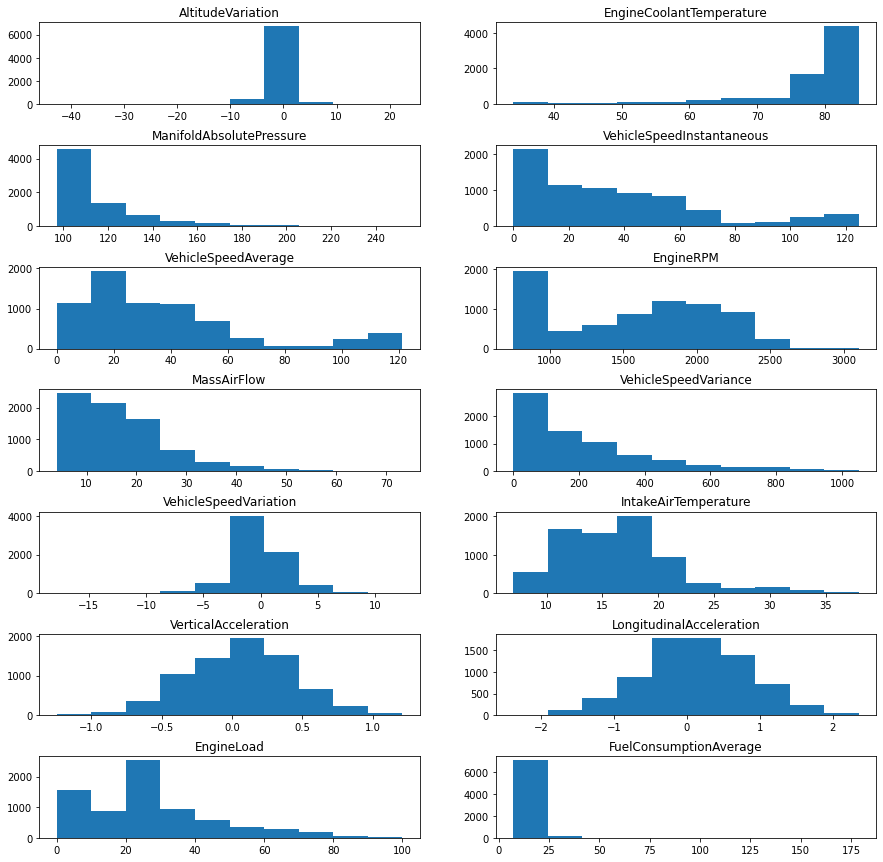

In [7]:
fig, axs = plt.subplots(7, 2, figsize=(15, 15))
cols = op_1_num_cols.columns
for i, col in enumerate(cols):
    axs[i%7, i%2].set_title(col)
    axs[i%7, i%2].hist(op_1_num_cols[col])
fig.subplots_adjust(hspace=0.5)
plt.show()

### Frequency Table for Dependent Variables

There is a large proportion of observations in one category in all of the dependent variables. From a naive perspective this is not good as there is not an even distribution of observations in each of the categories. This could mean that a different loss function may need to be used when training whatever classifier is decided upon.

In [8]:
print('Road Surface:')
print(pd.DataFrame(op_1['roadSurface'].value_counts(normalize=True)))
print('\nTraffic:')
print(pd.DataFrame(op_1['traffic'].value_counts(normalize=True)))
print('\nDriving Style:')
print(pd.DataFrame(op_1['drivingStyle'].value_counts(normalize=True)))

Road Surface:
                 roadSurface
SmoothCondition     0.977679
UnevenCondition     0.022321

Traffic:
                            traffic
LowCongestionCondition     0.921943
HighCongestionCondition    0.060741
NormalCongestionCondition  0.017316

Driving Style:
                 drivingStyle
EvenPaceStyle         0.81737
AggressiveStyle       0.18263


## Dataset 2: Opel Corsa Second Trip

### Correlation Heatmap

In [81]:
op_2_num_cols = op_2.drop(['roadSurface', 'traffic', 'drivingStyle'], axis=1)
corr = op_2_num_cols.corr()
corr.style.background_gradient(cmap='coolwarm')

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage
AltitudeVariation,1.000000,0.234097,0.254291,-0.038125,-0.066432,0.196324,0.165270,-0.098862,0.212907,0.084221,0.199227,-0.449122,0.233365,-0.027737
VehicleSpeedInstantaneous,0.234097,1.000000,0.895670,0.000906,0.029626,0.004401,0.337465,0.585778,0.758167,0.784843,0.810974,-0.254593,0.039431,-0.480205
VehicleSpeedAverage,0.254291,0.895670,1.000000,-0.025306,-0.079739,0.065431,0.293842,0.623869,0.637550,0.601836,0.662703,-0.363903,0.031589,-0.730585
VehicleSpeedVariance,-0.038125,0.000906,-0.025306,1.000000,0.007572,-0.004983,-0.003518,0.149273,0.062391,0.079253,0.051865,0.068487,-0.006286,-0.053830
VehicleSpeedVariation,-0.066432,0.029626,-0.079739,0.007572,1.000000,-0.054606,0.359504,-0.035147,0.303759,0.310866,0.307166,0.306623,0.009756,0.096536
LongitudinalAcceleration,0.196324,0.004401,0.065431,-0.004983,-0.054606,1.000000,0.001357,-0.111340,-0.010654,-0.028580,-0.022263,-0.167845,0.979422,0.058739
EngineLoad,0.165270,0.337465,0.293842,-0.003518,0.359504,0.001357,1.000000,0.110835,0.692409,0.244601,0.566677,-0.029075,0.044101,-0.040743
EngineCoolantTemperature,-0.098862,0.585778,0.623869,0.149273,-0.035147,-0.111340,0.110835,1.000000,0.450734,0.446793,0.444170,-0.010520,-0.144751,-0.696377
ManifoldAbsolutePressure,0.212907,0.758167,0.637550,0.062391,0.303759,-0.010654,0.692409,0.450734,1.000000,0.678639,0.930523,-0.058221,0.041878,-0.310568
EngineRPM,0.084221,0.784843,0.601836,0.079253,0.310866,-0.028580,0.244601,0.446793,0.678639,1.000000,0.810777,0.030562,0.042918,-0.312402


In [82]:
cutoff = 0.7

missing_corrs = corr[corr.index.isin(list(op_2_missing['column_name']))]
missing_corrs[abs(missing_corrs) > 0.8]

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage
AltitudeVariation,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehicleSpeedInstantaneous,NaN,1.00000,0.89567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.810974,NaN,NaN,NaN
VehicleSpeedAverage,NaN,0.89567,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehicleSpeedVariance,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehicleSpeedVariation,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FuelConsumptionAverage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


### Histogram for each variable to examine the distribution of variables

Interesting point to note here is that some of the distributions for variables in this dataset appear to not follow the same distribution as observed in the first trip. This will be investigated in more detail later.

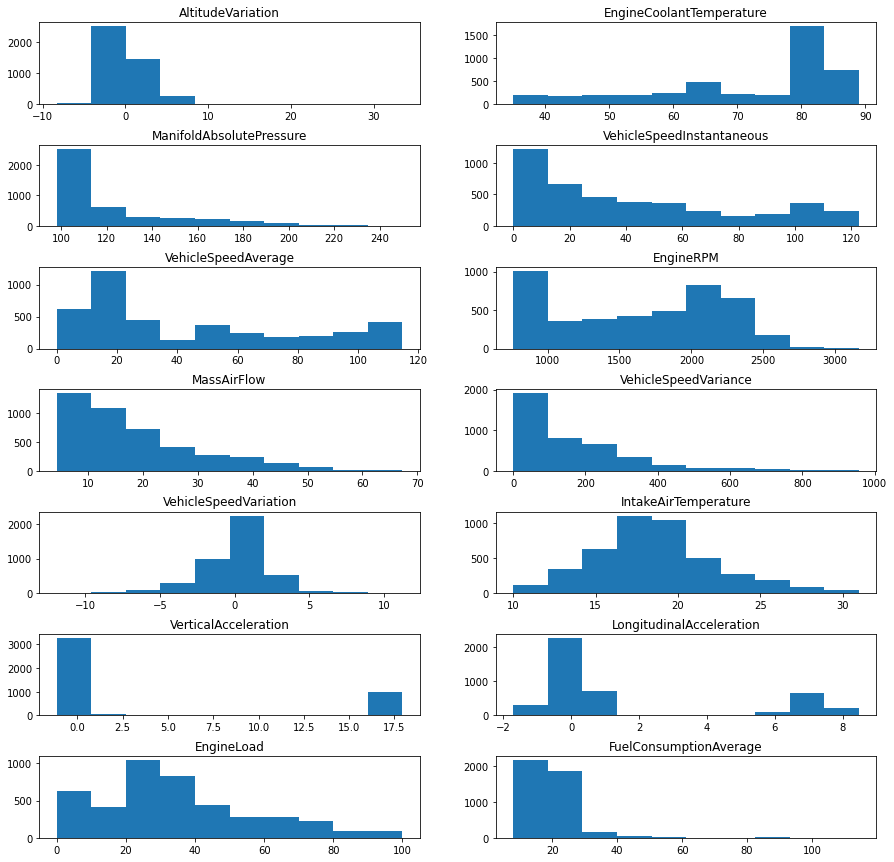

In [10]:
fig, axs = plt.subplots(7, 2, figsize=(15, 15))
cols = op_2_num_cols.columns
for i, col in enumerate(cols):
    axs[i%7, i%2].set_title(col)
    axs[i%7, i%2].hist(op_2_num_cols[col])
fig.subplots_adjust(hspace=0.5)
plt.show()

### Frequency Distribution

In [11]:
print('Road Surface:')
print(pd.DataFrame(op_2['roadSurface'].value_counts(normalize=True)))
print('\nTraffic:')
print(pd.DataFrame(op_2['traffic'].value_counts(normalize=True)))
print('\nDriving Style:')
print(pd.DataFrame(op_2['drivingStyle'].value_counts(normalize=True)))

Road Surface:
                 roadSurface
SmoothCondition     0.935305
UnevenCondition     0.064695

Traffic:
                            traffic
LowCongestionCondition     0.884242
NormalCongestionCondition  0.093577
HighCongestionCondition    0.022181

Driving Style:
                 drivingStyle
EvenPaceStyle        0.805915
AggressiveStyle      0.194085


### Some statistical tests on the Opel Corsa trips

Here I carry out t-tests for each variable of observations between the first and second trip. I form the null hypothesis as follows:

\begin{equation}
H_{0}: \mu_{1,j} = \mu_{2, j}
\end{equation}

Where $\mu_{1, j}$ is the mean of the variable $j$ in the first trip, $\mu_{2, j}$ is the mean of variable $j$ in the second trip and where $j$ is an element of the numerical feature set of our dataset. 

In [12]:
cols = op_1_num_cols.columns
significance_level = 0.05

for col in cols:
    ttest = ttest_ind(op_1_num_cols[col], op_2_num_cols[col], equal_var=False)
    p_val = ttest[1]
    if p_val < significance_level:
        sig = 'Reject H0'
    else:
        sig = 'Fail to reject H0'
    print('Variable {}, p={}, {}'.format(col, p_val, sig))

Variable AltitudeVariation, p=nan, Fail to reject H0
Variable VehicleSpeedInstantaneous, p=nan, Fail to reject H0
Variable VehicleSpeedAverage, p=nan, Fail to reject H0
Variable VehicleSpeedVariance, p=nan, Fail to reject H0
Variable VehicleSpeedVariation, p=nan, Fail to reject H0
Variable LongitudinalAcceleration, p=1.0751561451629979e-192, Reject H0
Variable EngineLoad, p=4.5049867426913175e-72, Reject H0
Variable EngineCoolantTemperature, p=7.363769776649215e-94, Reject H0
Variable ManifoldAbsolutePressure, p=8.086270028606376e-39, Reject H0
Variable EngineRPM, p=1.4178424758656799e-11, Reject H0
Variable MassAirFlow, p=4.401706612804365e-20, Reject H0
Variable IntakeAirTemperature, p=2.8206434765509914e-164, Reject H0
Variable VerticalAcceleration, p=3.7917470224337795e-252, Reject H0
Variable FuelConsumptionAverage, p=nan, Fail to reject H0


## Dataset 3: Peugeot 207 First Trip

### Correlation Heatmap

In [83]:
peug_1_num_cols = peug_1.drop(['roadSurface', 'traffic', 'drivingStyle'], axis=1)
corr = peug_1_num_cols.corr()
corr.style.background_gradient(cmap='coolwarm')

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage
AltitudeVariation,1.000000,0.160897,0.189482,-0.154431,-0.019992,0.001075,0.104905,0.191689,0.236993,0.134356,0.132389,0.223362,0.010894,-0.140362
VehicleSpeedInstantaneous,0.160897,1.000000,0.888643,-0.229725,0.035950,-0.139416,0.387396,0.237751,0.852394,0.923534,0.886846,0.563752,0.207268,-0.238502
VehicleSpeedAverage,0.189482,0.888643,1.000000,-0.133261,-0.058902,0.014691,0.377644,0.260765,0.758837,0.786129,0.724634,0.583103,0.038822,-0.575128
VehicleSpeedVariance,-0.154431,-0.229725,-0.133261,1.000000,0.041809,0.044937,-0.115622,-0.100536,-0.194882,-0.234508,-0.189467,-0.162882,-0.133467,-0.096751
VehicleSpeedVariation,-0.019992,0.035950,-0.058902,0.041809,1.000000,-0.172700,0.235637,-0.053115,0.141768,0.160844,0.183767,0.009895,0.166328,0.039206
LongitudinalAcceleration,0.001075,-0.139416,0.014691,0.044937,-0.172700,1.000000,-0.162806,0.303766,-0.192747,-0.191826,-0.254459,0.206810,-0.422724,-0.107423
EngineLoad,0.104905,0.387396,0.377644,-0.115622,0.235637,-0.162806,1.000000,0.018989,0.568009,0.404626,0.374510,0.262830,0.174774,-0.003403
EngineCoolantTemperature,0.191689,0.237751,0.260765,-0.100536,-0.053115,0.303766,0.018989,1.000000,0.255052,0.210627,0.086936,0.855562,-0.153322,-0.412194
ManifoldAbsolutePressure,0.236993,0.852394,0.758837,-0.194882,0.141768,-0.192747,0.568009,0.255052,1.000000,0.829798,0.844277,0.627692,0.247940,-0.189212
EngineRPM,0.134356,0.923534,0.786129,-0.234508,0.160844,-0.191826,0.404626,0.210627,0.829798,1.000000,0.947320,0.517956,0.254429,-0.207173


In [84]:
cutoff = 0.7

missing_corrs = corr[corr.index.isin(list(peug_1_missing['column_name']))]
missing_corrs[abs(missing_corrs) > 0.8]

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage
AltitudeVariation,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehicleSpeedInstantaneous,NaN,1.000000,0.888643,NaN,NaN,NaN,NaN,NaN,0.852394,0.923534,0.886846,NaN,NaN,NaN
VehicleSpeedAverage,NaN,0.888643,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehicleSpeedVariance,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehicleSpeedVariation,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EngineLoad,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EngineCoolantTemperature,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.855562,NaN,NaN
ManifoldAbsolutePressure,NaN,0.852394,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.829798,0.844277,NaN,NaN,NaN
EngineRPM,NaN,0.923534,NaN,NaN,NaN,NaN,NaN,NaN,0.829798,1.000000,0.947320,NaN,NaN,NaN
MassAirFlow,NaN,0.886846,NaN,NaN,NaN,NaN,NaN,NaN,0.844277,0.947320,1.000000,NaN,NaN,NaN


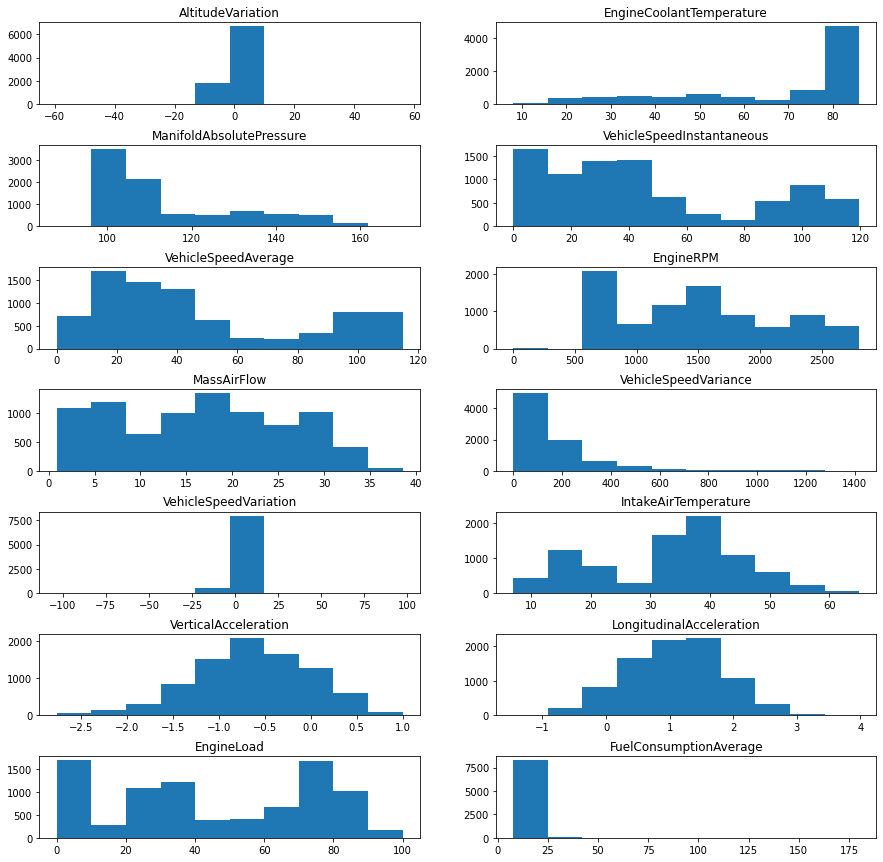

In [14]:
fig, axs = plt.subplots(7, 2, figsize=(15, 15))
cols = peug_1_num_cols.columns
for i, col in enumerate(cols):
    axs[i%7, i%2].set_title(col)
    axs[i%7, i%2].hist(peug_1_num_cols[col])
fig.subplots_adjust(hspace=0.5)
plt.show()

### Frequency Distribution

In [15]:
print('Road Surface:')
print(pd.DataFrame(peug_1['roadSurface'].value_counts(normalize=True)))
print('\nTraffic:')
print(pd.DataFrame(peug_1['traffic'].value_counts(normalize=True)))
print('\nDriving Style:')
print(pd.DataFrame(peug_1['drivingStyle'].value_counts(normalize=True)))

Road Surface:
                      roadSurface
SmoothCondition          0.428256
UnevenCondition          0.353146
FullOfHolesCondition     0.218598

Traffic:
                            traffic
LowCongestionCondition     0.842698
NormalCongestionCondition  0.080799
HighCongestionCondition    0.076503

Driving Style:
                 drivingStyle
EvenPaceStyle           0.943
AggressiveStyle         0.057


## Dataset 4: Peugeot 207 Second Trip

Some of the variables that are correlated here with variables with missing values in the first trip could be used to impute missing values using a simple linear regression.

In [85]:
peug_2_num_cols = peug_2.drop(['roadSurface', 'traffic', 'drivingStyle'], axis=1)
corr = peug_2_num_cols.corr()
corr.style.background_gradient(cmap='coolwarm')

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage
AltitudeVariation,1.000000,-0.082131,-0.015387,-0.094993,-0.026424,0.057511,-0.010857,0.090370,-0.049957,-0.088289,-0.113558,0.059569,-0.049135,-0.171064
VehicleSpeedInstantaneous,-0.082131,1.000000,0.626639,0.306657,0.057453,-0.120136,-0.080945,0.351200,0.601428,0.786969,0.755654,0.401378,0.121728,-0.285697
VehicleSpeedAverage,-0.015387,0.626639,1.000000,0.289616,-0.119886,0.319702,-0.082970,0.472258,0.329691,0.414477,0.379570,0.364536,-0.323347,-0.684859
VehicleSpeedVariance,-0.094993,0.306657,0.289616,1.000000,0.056732,0.062429,0.049470,0.187364,0.260916,0.240439,0.197566,0.254186,-0.060490,-0.228545
VehicleSpeedVariation,-0.026424,0.057453,-0.119886,0.056732,1.000000,-0.202899,0.219346,-0.024736,0.306167,0.321925,0.331470,0.066853,0.223718,0.041240
LongitudinalAcceleration,0.057511,-0.120136,0.319702,0.062429,-0.202899,1.000000,-0.153458,0.141907,-0.181383,-0.168323,-0.192191,-0.076453,-0.779536,-0.153300
EngineLoad,-0.010857,-0.080945,-0.082970,0.049470,0.219346,-0.153458,1.000000,-0.104226,0.240985,0.050932,0.005721,0.002558,0.138069,0.096092
EngineCoolantTemperature,0.090370,0.351200,0.472258,0.187364,-0.024736,0.141907,-0.104226,1.000000,0.355105,0.263796,0.167342,0.826453,-0.116012,-0.596888
ManifoldAbsolutePressure,-0.049957,0.601428,0.329691,0.260916,0.306167,-0.181383,0.240985,0.355105,1.000000,0.710845,0.694617,0.569625,0.174622,-0.239960
EngineRPM,-0.088289,0.786969,0.414477,0.240439,0.321925,-0.168323,0.050932,0.263796,0.710845,1.000000,0.921109,0.341510,0.208628,-0.193741


In [86]:
cutoff = 0.7

missing_corrs = corr[corr.index.isin(list(peug_2_missing['column_name']))]
missing_corrs[abs(missing_corrs) > 0.8]

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage
AltitudeVariation,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehicleSpeedInstantaneous,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehicleSpeedAverage,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehicleSpeedVariance,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehicleSpeedVariation,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FuelConsumptionAverage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


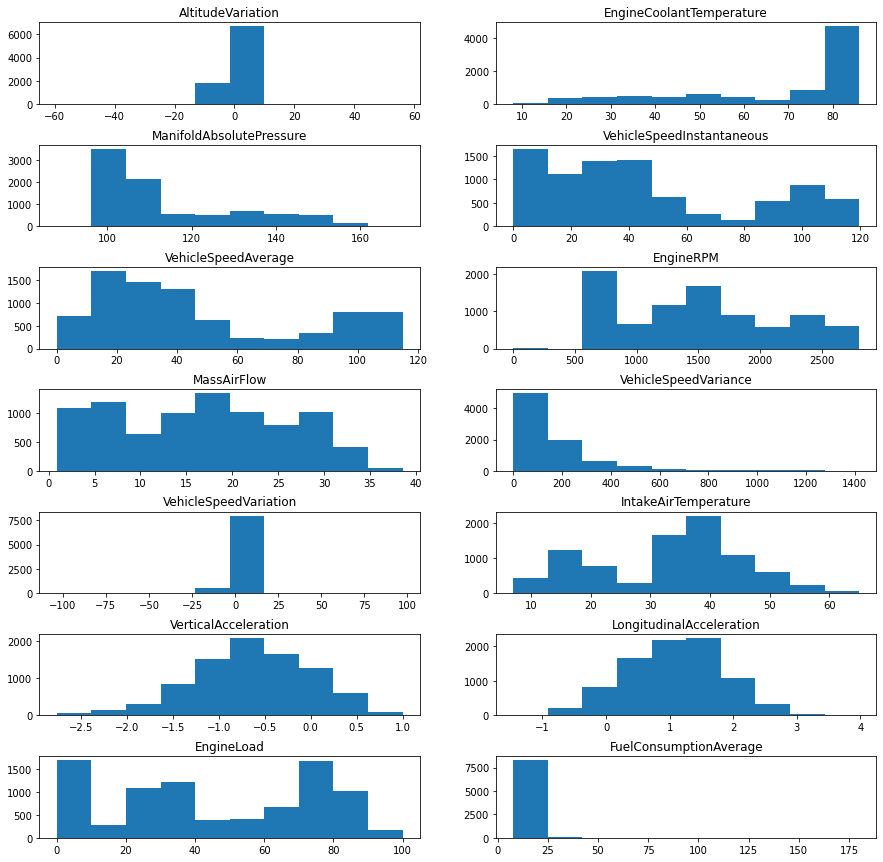

In [17]:
fig, axs = plt.subplots(7, 2, figsize=(15, 15))
cols = peug_1_num_cols.columns
for i, col in enumerate(cols):
    axs[i%7, i%2].set_title(col)
    axs[i%7, i%2].hist(peug_1_num_cols[col])
fig.subplots_adjust(hspace=0.5)
plt.show()

In [18]:
print('Road Surface:')
print(pd.DataFrame(peug_2['roadSurface'].value_counts(normalize=True)))
print('\nTraffic:')
print(pd.DataFrame(peug_2['traffic'].value_counts(normalize=True)))
print('\nDriving Style:')
print(pd.DataFrame(peug_2['drivingStyle'].value_counts(normalize=True)))

Road Surface:
                      roadSurface
UnevenCondition          0.644387
FullOfHolesCondition     0.295479
SmoothCondition          0.060134

Traffic:
                            traffic
NormalCongestionCondition  0.420074
HighCongestionCondition    0.392170
LowCongestionCondition     0.187757

Driving Style:
                 drivingStyle
EvenPaceStyle         0.95955
AggressiveStyle       0.04045


# Let's combine the data

I will first combine the data on a per-vehicle basis. That is, I will combine the two trips for Opel, and the two trips for Peugot into two different datasets and examine distributions of some variables

In [19]:
op = pd.concat([op_1, op_2])
peug = pd.concat([peug_1, peug_2])

In [20]:
print('Combined rows in Opel dataset: {}'.format(op.shape))
print('Combined rows in Peugeot dataset: {}'.format(peug.shape))

Combined rows in Opel dataset: (11720, 17)
Combined rows in Peugeot dataset: (13237, 17)


# Combine all trip datasets together

There's clearly a class imbalance here for the ```traffic``` and ```drivingStyle``` variables. This may be combatted later by optimizing using precision or recall as a loss function instead of raw accuracy. 

Useful link on class imbalance and methods that can be used to overcome this barrier:

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

Might be good to use a random forest classifier here which naturally deals well with imbalanced classes.

In [88]:
df_total = pd.concat([op_1, op_2, peug_1, peug_2])
print('Road Surface:')
print(pd.DataFrame(df_total['roadSurface'].value_counts(normalize=True)))
print('\nTraffic:')
print(pd.DataFrame(df_total['traffic'].value_counts(normalize=True)))
print('\nDriving Style:')
print(pd.DataFrame(df_total['drivingStyle'].value_counts(normalize=True)))

Road Surface:
                      roadSurface
SmoothCondition          0.610730
UnevenCondition          0.259086
FullOfHolesCondition     0.130184

Traffic:
                            traffic
LowCongestionCondition     0.752054
NormalCongestionCondition  0.127059
HighCongestionCondition    0.120888

Driving Style:
                 drivingStyle
EvenPaceStyle        0.885082
AggressiveStyle      0.114918


In [89]:
df_total_num_cols = df_total.drop(['roadSurface', 'traffic', 'drivingStyle'], axis=1)
corr = df_total_num_cols.corr()
corr.style.background_gradient(cmap='coolwarm')

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage
AltitudeVariation,1.000000,0.039925,0.048461,-0.105764,-0.022569,0.066469,0.084832,0.062140,0.091195,0.008833,0.037743,0.083853,0.090439,-0.099585
VehicleSpeedInstantaneous,0.039925,1.000000,0.866996,-0.053651,0.035507,0.036011,0.258527,0.271006,0.721994,0.836510,0.814013,0.352477,0.051352,-0.306325
VehicleSpeedAverage,0.048461,0.866996,1.000000,-0.035565,-0.073399,0.166236,0.257029,0.297263,0.604728,0.650418,0.636945,0.348124,0.023547,-0.616450
VehicleSpeedVariance,-0.105764,-0.053651,-0.035565,1.000000,0.034896,-0.020677,-0.081578,0.069631,-0.000171,-0.004905,0.007511,-0.111069,-0.012316,-0.110030
VehicleSpeedVariation,-0.022569,0.035507,-0.073399,0.034896,1.000000,-0.105250,0.262929,-0.038259,0.237444,0.234851,0.255950,0.052458,0.029264,0.049920
LongitudinalAcceleration,0.066469,0.036011,0.166236,-0.020677,-0.105250,1.000000,-0.009332,0.057896,0.010751,-0.025586,-0.024719,0.138148,0.748218,-0.028905
EngineLoad,0.084832,0.258527,0.257029,-0.081578,0.262929,-0.009332,1.000000,-0.089954,0.444213,0.203067,0.313124,0.298523,-0.008948,-0.003971
EngineCoolantTemperature,0.062140,0.271006,0.297263,0.069631,-0.038259,0.057896,-0.089954,1.000000,0.277907,0.269922,0.188907,0.337333,-0.009649,-0.436901
ManifoldAbsolutePressure,0.091195,0.721994,0.604728,-0.000171,0.237444,0.010751,0.444213,0.277907,1.000000,0.709298,0.869847,0.208743,0.128892,-0.187932
EngineRPM,0.008833,0.836510,0.650418,-0.004905,0.234851,-0.025586,0.203067,0.269922,0.709298,1.000000,0.873557,0.262213,0.106690,-0.217941


## Modelling part

First try a logistic regression and random forest classification model

In [93]:
df_model = df_total.dropna()
X = df_model.drop(['roadSurface', 'traffic', 'drivingStyle'], axis=1)
y_1 = df_model['roadSurface']
y_2 = df_model['traffic']
y_3 = df_model['drivingStyle']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y_1, test_size = 0.25)

In [95]:
sc = StandardScaler()

In [96]:
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [99]:
X_train_std

array([[ 0.69995636,  0.82302589,  0.60325236, ...,  0.78397888,
         0.24630059, -0.70755191],
       [ 0.12725488, -1.1377485 , -0.72162531, ..., -0.40926961,
        -0.21525968,  0.01180488],
       [-0.11137134, -0.71345811,  0.4416934 , ..., -0.50105795,
        -0.23581465, -0.44752961],
       ...,
       [ 0.60450733,  1.98889173,  2.23205911, ...,  1.88543901,
        -0.30830708, -1.06475781],
       [ 0.50905647, -0.36933694,  0.15781182, ...,  0.60040219,
        -0.1871486 , -1.03490695],
       [-0.25454125, -1.1377485 , -0.70794908, ..., -1.14357637,
        -0.12713389,  1.10282631]])

In [103]:
eigen_vals, eigen_vec = np.linalg.eig(np.cov(X_train_std.T))

In [106]:
len(eigen_vals)

14

In [108]:
len(var_exp)

14

In [109]:
len(cum_var_exp)

14

In [110]:
len(range(1, 14))

13

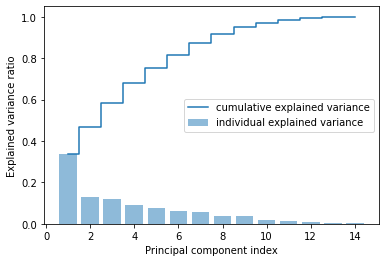

In [111]:
# calculate cumulative sum of explained variances
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.bar(range(1,15), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,15), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [38]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [39]:
rf_clf.score(X_test, y_test)

0.9892274027941425